In [1]:
import math 
import pandas_datareader as web
import numpy as np
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [2]:
df = web.DataReader('TSLA', data_source='yahoo', start='2012-01-01', end='2019-01-01')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,5.900000,5.530000,5.788000,5.616000,4640500,5.616000
2012-01-04,5.734000,5.500000,5.642000,5.542000,3150500,5.542000
2012-01-05,5.586000,5.370000,5.552000,5.424000,5027500,5.424000
2012-01-06,5.558000,5.282000,5.440000,5.382000,4931500,5.382000
2012-01-09,5.498000,5.224000,5.400000,5.450000,4485000,5.450000
...,...,...,...,...,...,...
2018-12-24,62.900002,59.040001,62.700001,59.077999,27799500,59.077999
2018-12-26,65.393997,58.818001,60.000000,65.218002,40815500,65.218002
2018-12-27,64.433998,60.299999,63.967999,63.226002,42875500,63.226002


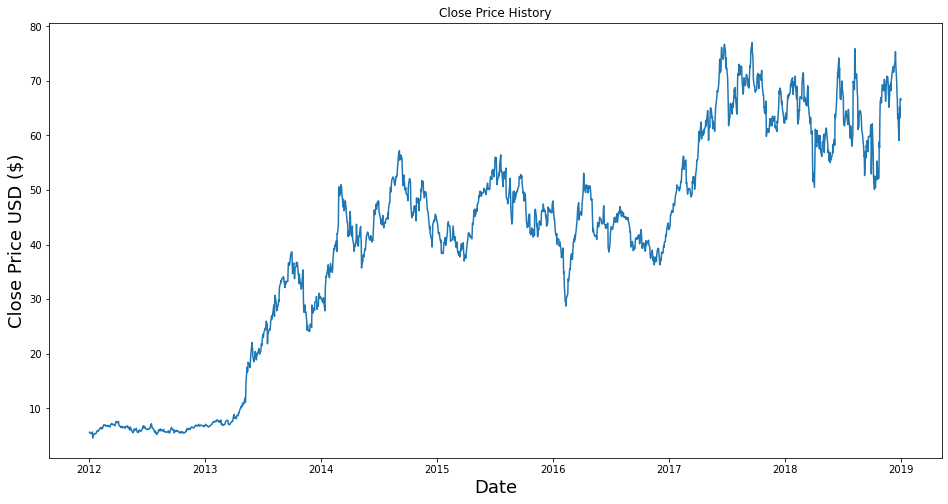

In [3]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [4]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)
